In [1]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
def random_matrix(n, p=0):
    r_matrix = np.random.uniform(0, 1, (n, n))
    for ind in np.random.permutation(range(n*n))[:int(n*n*p)]:
        r_matrix[ind // n, ind % n] = 0
    return r_matrix

In [3]:
def truncated_svd(A, k):
    if not 0 < k < A.shape[0] + 1:
        raise ValueError("k should between 0 and A.shape[0] + 1")
    if k == A.shape[0]:
        U, s, V = svd(A)
    else:
        U, s, V = svds(A, k)
        U, s, V = U[::, ::-1], s[::-1], V[::-1]
    return U, s, V

In [4]:
def calculate_singular_values(matrix):
    return svd(matrix)[1]

def plot_singular_values(values):
    plt.plot(values)

def power_of_two(x):
    while x % 2:
        x //= 2
    return x != 1

In [5]:
class Node:
    def __init__(self, lp=None, rp=None, ld=None, rd=None):
        self.lp = lp
        self.rp = rp
        self.ld = ld
        self.rd = rd

    def eval(self, length):
        matrix = np.zeros((length, length))
        length //= 2
        matrix[:length, :length] = self.lp.eval(length)
        matrix[:length, length:] = self.rp.eval(length)
        matrix[length:, :length] = self.ld.eval(length)
        matrix[length:, length:] = self.rd.eval(length)
        return matrix


class Leaf:
    def __init__(self, U=None, V=None, s=None, zeros=False):
        self.U = U
        self.s = s
        self.V = V
        self.zeros = zeros

    def eval(self, length):
        if self.zeros:
            return 0
        return self.U @ np.diag(self.s) @ self.V

In [6]:
eps = 1e-12

In [7]:
def compress(matrix, min_value, max_rank, left, up, length):
    if length == 1:
        return Leaf(U=matrix, s=np.array([1]), V=np.array([1]))
    else:
        if length <= max_rank + 1:
            max_rank = length - 1
        U, s, V  = truncated_svd(matrix, k=max_rank + 1)
        if np.abs(s[-1]) < min_value + eps:
            s_values = s[np.abs(s) >= min_value + eps]
            k = s_values.shape[0]
            if k == 0:
                return Leaf(zeros=True)
            return Leaf(U=U[::, :k], s=s_values, V=V[:k])
        length //= 2
        node = Node(
            lp=compress(matrix[:length, :length], min_value, max_rank, left, up, length),
            rp=compress(matrix[:length, length:], min_value, max_rank, left + length, up, length),
            ld=compress(matrix[length:, :length], min_value, max_rank, left, up + length, length),
            rd=compress(matrix[length:, length:], min_value, max_rank, left + length, up+length, length)
        )
        return node


def compress_matrix(matrix, min_value, max_rank):
    if max_rank > matrix.shape[0] - 1:
        raise ValueError("Maximum rank should be strictly less than matrix dimension")
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("Matrix should be square")
    if not power_of_two(matrix.shape[0]):
        raise ValueError("Matrix dimension should be power of two")
    n, _ = matrix.shape
    return compress(matrix, abs(min_value), max_rank, 0, 0, matrix.shape[0])


In [8]:
mat = random_matrix(64, 0.5)
v = calculate_singular_values(mat)
# plot_singular_values(v)
print(mat)

[[0.         0.57930113 0.86888175 ... 0.         0.         0.        ]
 [0.         0.         0.20011056 ... 0.         0.55135368 0.        ]
 [0.         0.         0.         ... 0.1302988  0.14377107 0.84099267]
 ...
 [0.         0.79843166 0.53276778 ... 0.08124003 0.         0.12531655]
 [0.         0.35156603 0.56730555 ... 0.83410284 0.45003181 0.16368447]
 [0.         0.4825772  0.24200647 ... 0.         0.         0.40473685]]


In [9]:
image_mat = np.full((64, 64), 255)
tree_root = compress_matrix(mat, v[-1], 1)
image = Image.fromarray(image_mat)
image.show()

In [10]:
mat2 = tree_root.eval(64)
print(mat2)

[[ 0.00000000e+00  5.79301131e-01  8.68881752e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.00110561e-01 ...  0.00000000e+00
   5.51353676e-01  0.00000000e+00]
 [-1.01614770e-16 -8.48122568e-17  0.00000000e+00 ...  1.30298802e-01
   1.43771071e-01  8.40992667e-01]
 ...
 [ 0.00000000e+00  7.98431660e-01  5.32767775e-01 ...  8.12400317e-02
   0.00000000e+00  1.25316547e-01]
 [ 0.00000000e+00  3.51566032e-01  5.67305551e-01 ...  8.34102838e-01
   4.50031812e-01  1.63684469e-01]
 [ 0.00000000e+00  4.82577200e-01  2.42006468e-01 ...  0.00000000e+00
   0.00000000e+00  4.04736845e-01]]


In [11]:
a, b, c = svds(mat, k=10)
print(a.shape)
print(b.shape)
print(c.shape)

(64, 10)
(10,)
(10, 64)


In [12]:
print(a @ np.diag(b) @ c)

[[-0.0670757   0.19585885  0.64607877 ...  0.21911569  0.24157643
   0.01488144]
 [ 0.27620442  0.03757629  0.53841466 ... -0.06644299  0.52463582
   0.26700521]
 [ 0.2718486   0.05325942  0.06786681 ...  0.23488246  0.00483007
   0.40058718]
 ...
 [ 0.00832506  0.47591692  0.23636678 ...  0.53123037  0.27934594
   0.23434861]
 [-0.28305653  0.36844512  0.35624061 ...  0.58466759  0.29221785
   0.32443286]
 [ 0.18082051  0.1860103   0.33024235 ...  0.19442313  0.0148998
   0.34456728]]


In [35]:
matrix = random_matrix(128, 0.99)
matrix_tree = compress_matrix(matrix, v[-1], 1)

In [36]:
def max_depth(root):
    if isinstance(root, Leaf):
        return 0
    else:
        max_value = 1 + max(max_depth(root.lp), max_depth(root.rp), max_depth(root.ld), max_depth(root.rd))
        
        return max_value

In [37]:
def get_print_sizes(size, root):
    max_d = max_depth(root)
    
    print_sizes = []
    
    current_size = size // (2 ** max_d)
    
    for _ in range(max_d + 1):
        print_sizes.append(current_size)
        
        current_size = 2 * print_sizes[-1] + 1
    
    return print_sizes[::-1]

In [38]:
print_sizes = get_print_sizes(128, matrix_tree)

In [39]:
def printer(root, depth=0):
    if isinstance(root, Leaf):
        size = print_sizes[depth]
        if root.zeros:
            array = np.ones((size, size))
        else:
            array = np.zeros((size, size))
            k = len(root.s)
            array[k:, k:] = np.ones((size - k, size - k))
        
        return array
    else:
        top_left = printer(root.lp, depth + 1)
        top_right = printer(root.rp, depth + 1)
        bottom_left = printer(root.ld, depth + 1)
        bottom_right = printer(root.rd, depth + 1)

        
        size = print_sizes[depth]
        
        base = np.ones((size, size)) * 0.5
        k = size // 2
        
        base[:k, :k] = top_left
        base[:k, k + 1:] = top_right
        base[k + 1:, :k] = bottom_left
        base[k + 1:, k + 1:] = bottom_right
        
        return base

In [40]:
image = printer(matrix_tree) * 255

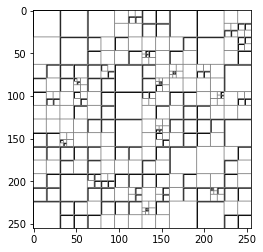

In [41]:
plt.imshow(image)
plt.gray()
plt.show()